## This notebook exists to calculate sunspot numbers over different time periods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter, find_peaks

The Sunspot number data comes from the royal observatory of belgium:
https://www.sidc.be/SILSO/datafiles

Some information can be found here:
https://www.sidc.be/SILSO/infosnmtot

In [2]:
spots_real = pd.read_csv('BelgiumMonthlySunspotNum.csv')

The goal of the next section is to algorithmically find regions of peaks and troughs. Although a ~11 year cycle exists, the lengths of each cycle, as well as the solar minima and maxima vary.

Here, the first step is to select quality data, and then smooth the values using a Savitzky-Golay filter, with a window of 36 months, fitting a parabola. This is done in order to more easily find peaks.

Residuals are plotted, although not entirely homoscedastic, they are reasonable. Especially as the smoothed values are used only to find the peaks and troughs 

(1749.042, 2024.206)

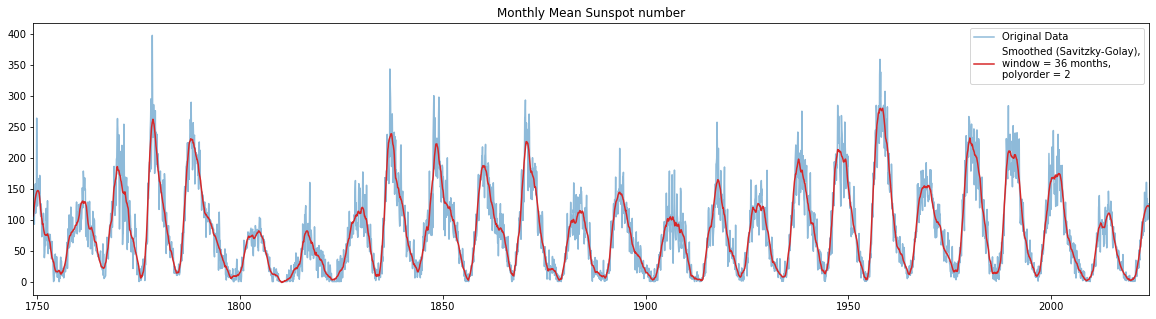

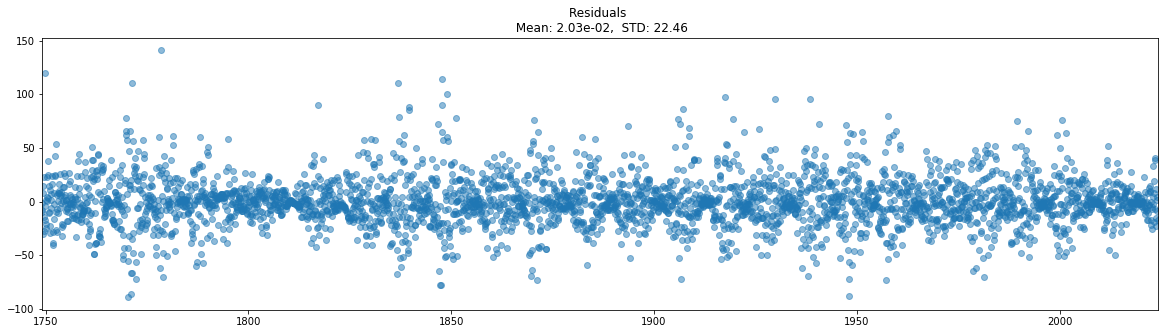

In [3]:
dates = spots_real['Fractional_Date'][spots_real['Definitive_Provisional_Marker'] == 1]
spots = spots_real['Monthly_Mean_Sunspot_Number'][spots_real['Definitive_Provisional_Marker'] == 1]


sunspots_smoothed = savgol_filter(spots, window_length=36, polyorder=2)

plt.figure(figsize = (20,5))
plt.plot(dates, spots, alpha = 0.5, label = 'Original Data')
plt.plot(dates, sunspots_smoothed, label='Smoothed (Savitzky-Golay),\nwindow = 36 months,\npolyorder = 2', color = 'tab:red')
plt.xlim(dates.iloc[0], dates.iloc[-1])
plt.title('Monthly Mean Sunspot number')
plt.legend()

residuals = spots - sunspots_smoothed
resid_mean = np.mean(residuals)
resid_std  = np.std(residuals)

plt.figure(figsize = (20,5))
plt.scatter(dates, residuals, alpha = 0.5)
plt.title(f'Residuals \n Mean: {resid_mean:.2e},  STD: {resid_std:.2f}')
plt.xlim(dates.iloc[0], dates.iloc[-1])


### Peak finding

(1749.042, 2024.206)

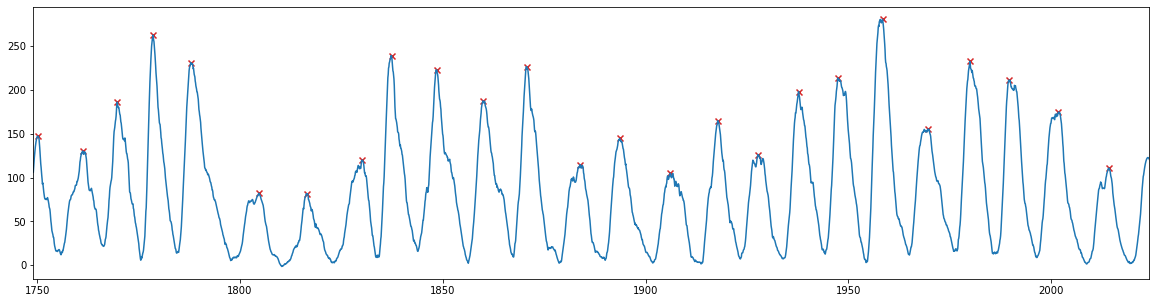

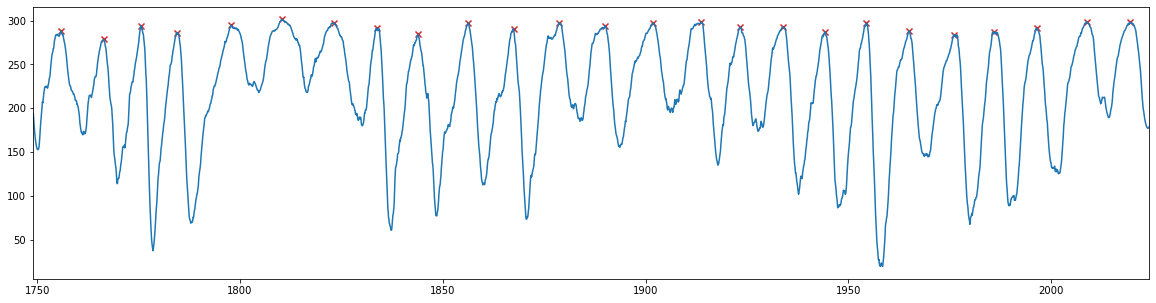

In [4]:
peaks = find_peaks(sunspots_smoothed, distance = 36, prominence=15)[0]

plt.figure(figsize = (20,5))
plt.plot(dates, sunspots_smoothed, label='Smoothed Sunspot Number')
plt.scatter(dates[peaks], sunspots_smoothed[peaks], marker = 'x', color = 'tab:red')
plt.xlim(dates.iloc[0], dates.iloc[-1])

troughs = find_peaks(300-sunspots_smoothed, distance = 36, prominence=15)[0]

plt.figure(figsize = (20,5))
plt.plot(dates, 300-sunspots_smoothed, label='Smoothed Sunspot Number')
plt.scatter(dates[troughs], 300-sunspots_smoothed[troughs], marker = 'x', color = 'tab:red')
plt.xlim(dates.iloc[0], dates.iloc[-1])

### Region selecting
Note, some of this code was written with AI assistance (claude)

Here, a peak region is defined as 0.85x the local peak, and a trough is 2x (trough + 5) spots. Any discontinuities to these regions are cut out

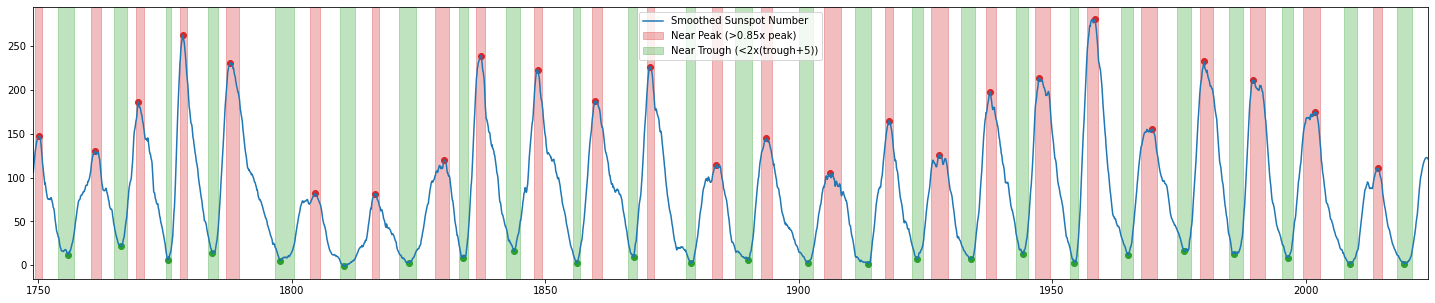

In [5]:
def plot_and_get_regions(dates, sunspots_smoothed, peaks, troughs):
    # Initialize arrays to store the regions
    peak_regions = []    # Will store tuples of (start_idx, end_idx)
    trough_regions = []  # Will store tuples of (start_idx, end_idx)
    
    plt.figure(figsize=(25,5))
    plt.plot(dates, sunspots_smoothed, label='Smoothed Sunspot Number')
    plt.scatter(dates[peaks], sunspots_smoothed[peaks], marker='o', color='tab:red')
    plt.scatter(dates[troughs], sunspots_smoothed[troughs], marker='o', color='tab:green')
    plt.xlim(dates.iloc[0], dates.iloc[-1])

    # For each peak, highlight regions where values are >90% of peak
    for i in range(len(peaks)):
        peak_value = sunspots_smoothed[peaks[i]]
        threshold = 0.85 * peak_value
        peak_idx = peaks[i]
        
        above_threshold = sunspots_smoothed >= threshold
        region_changes = np.diff(above_threshold.astype(int))
        region_starts = np.where(region_changes == 1)[0] + 1
        region_ends = np.where(region_changes == -1)[0] + 1
        
        if above_threshold[0]:
            region_starts = np.insert(region_starts, 0, 0)
        if above_threshold[-1]:
            region_ends = np.append(region_ends, len(above_threshold))
        
        if len(region_starts) > 0:
            region_centers = (region_starts + region_ends) / 2
            closest_region_idx = np.argmin(np.abs(region_centers - peak_idx))
            
            start = int(region_starts[closest_region_idx])
            end = int(region_ends[closest_region_idx])
            plt.axvspan(dates[start], dates[end], alpha=0.3, color='tab:red', 
                       label='Near Peak (>0.85x peak)' if i==0 else "")
            peak_regions.append((start, end))

    # For each trough, highlight regions where values are <2x trough
    for i in range(len(troughs)):
        trough_value = sunspots_smoothed[troughs[i]]
        threshold = 2 * (trough_value+5)
        trough_idx = troughs[i]
        
        below_threshold = sunspots_smoothed <= threshold
        region_changes = np.diff(below_threshold.astype(int))
        region_starts = np.where(region_changes == 1)[0] + 1
        region_ends = np.where(region_changes == -1)[0] + 1
        
        if below_threshold[0]:
            region_starts = np.insert(region_starts, 0, 0)
        if below_threshold[-1]:
            region_ends = np.append(region_ends, len(below_threshold))
        
        if len(region_starts) > 0:
            region_centers = (region_starts + region_ends) / 2
            closest_region_idx = np.argmin(np.abs(region_centers - trough_idx))
            
            start = int(region_starts[closest_region_idx])
            end = int(region_ends[closest_region_idx])
            plt.axvspan(dates[start], dates[end], alpha=0.3, color='tab:green', 
                       label='Near Trough (<2x(trough+5))' if i==0 else "")
            trough_regions.append((start, end))

    plt.legend()
    return peak_regions, trough_regions

# Usage:
peak_regions, trough_regions = plot_and_get_regions(dates, sunspots_smoothed, peaks, troughs)


In [6]:
peak_idx = np.concatenate([np.arange(tup[0], tup[1]+1) for tup in peak_regions])
trough_idx = np.concatenate([np.arange(tup[0], tup[1]+1) for tup in trough_regions])

peak_region_vals = spots[peak_idx]
trough_region_vals = spots[trough_idx]

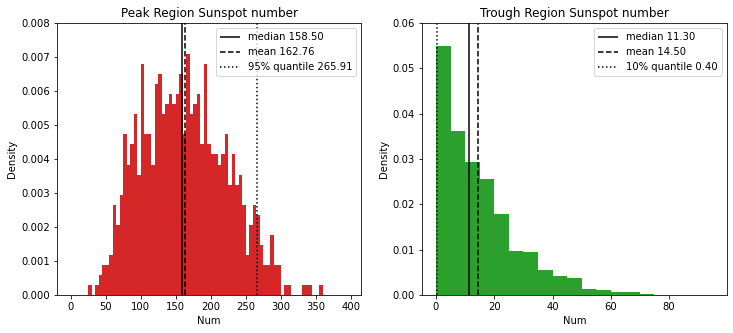

In [7]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
_ = plt.hist(peak_region_vals, bins = np.arange(0, 400, 5), density = True, color = 'tab:red')
plt.title('Peak Region Sunspot number')
plt.xlabel('Num')
plt.ylabel('Density')
plt.vlines(np.median(peak_region_vals), 0, 0.009, ls = '-', color = 'black', label = f'median {np.median(peak_region_vals):.2f}')
plt.vlines(np.mean(peak_region_vals), 0, 0.009, ls = '--', color = 'black', label =  f'mean {np.mean(peak_region_vals):.2f}')
plt.vlines(np.quantile(peak_region_vals, 0.95), 0, 0.009, ls = ':', color = 'black', label =  f'95% quantile {np.quantile(peak_region_vals, 0.95):.2f}')
plt.legend()
plt.ylim([0,0.008])

plt.subplot(1,2,2)
_ = plt.hist(trough_region_vals, bins = np.arange(0, 100, 5), density = True, color = 'tab:green')
plt.title('Trough Region Sunspot number')
plt.xlabel('Num')
plt.ylabel('Density')
plt.ylim([0,0.06])
plt.vlines(np.median(trough_region_vals), 0, 0.06, ls = '-', color = 'black', label = f'median {np.median(trough_region_vals):.2f}')
plt.vlines(np.mean(trough_region_vals), 0, 0.06, ls = '--', color = 'black', label = f'mean {np.mean(trough_region_vals):.2f}')
plt.vlines(np.quantile(trough_region_vals, 0.1), 0, 0.06, ls = ':', color = 'black', label =  f'10% quantile {np.quantile(trough_region_vals, 0.1):.2f}')
plt.legend()
